# Opentrons Digits

Inspired by: https://github.com/jmtomczak/intro_dgm/blob/main/ddgms/ddgm_example.ipynb

In [16]:
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt

In [22]:
RESULTS_DIR = Path().resolve().parent.joinpath("results")

## Dataset
The Opentron exercise is done on 96-well plates and it just so happens that the images in the scikit-learn digits so the images dataset are 8x8.
There are ~1500 images to train on and each pixel can take values in {0,1,...,16}.

In [80]:
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode="train", transforms=None):
        digits = load_digits()
        # We only have 4 colors so we divide each pixel by 4 to end up with 4 values
        data = digits.data // 4
        if mode == "train":
            self.data = data[:1000].astype(np.float32)
        elif mode == "val":
            self.data = data[1000:1350].astype(np.float32)
        else:
            self.data = data[1350:].astype(np.float32)

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transforms:
            sample = self.transforms(sample)
        return sample

## Auxiliary functions and classes

In [81]:
PI = torch.from_numpy(np.asarray(np.pi))
EPS = 1.e-7

def log_categorical(x, p, num_classes=256, reduction=None, dim=None):
    x_one_hot = F.one_hot(x.long(), num_classes=num_classes)
    log_p = x_one_hot * torch.log(torch.clamp(p, EPS, 1. - EPS))
    if reduction == "avg":
        return torch.mean(log_p, dim)
    elif reduction == "sum":
        return torch.sum(log_p, dim)
    else:
        return log_p
    
def log_bernoulli(x, p, reduction=None, dim=None):
    pp = torch.clamp(p, EPS, 1. - EPS)
    log_p = x * torch.log(pp) + (1. - x) * torch.log(1. - pp)
    if reduction == "avg":
        return torch.mean(log_p, dim)
    elif reduction == "sum":
        return torch.sum(log_p, dim)
    else:
        return log_p

def log_normal_diag(x, mu, log_var, reduction=None, dim=None):
    log_p = -0.5 * torch.log(2. * PI) - 0.5 * log_var - 0.5 * torch.exp(-log_var) * (x - mu)**2.
    if reduction == "avg":
        return torch.mean(log_p, dim)
    elif reduction == "sum":
        return torch.sum(log_p, dim)
    else:
        return log_p

def log_standard_normal(x, reduction=None, dim=None):
    log_p = -0.5 * torch.log(2. * PI) - 0.5 * x**2.
    if reduction == "avg":
        return torch.mean(log_p, dim)
    elif reduction == "sum":
        return torch.sum(log_p, dim)
    else:
        return log_p

# Chakraborty & Chakravarty, "A new discrete probability distribution with integer support on (−∞, ∞)",
# Communications in Statistics - Theory and Methods, 45:2, 492-505, DOI: 10.1080/03610926.2013.830743

def log_min_exp(a, b, epsilon=1e-8):
    """
    Source: https://github.com/jornpeters/integer_discrete_flows
    Computes the log of exp(a) - exp(b) in a (more) numerically stable fashion.
    Using:
    log(exp(a) - exp(b))
    c + log(exp(a-c) - exp(b-c))
    a + log(1 - exp(b-a))
    And note that we assume b < a always.
    """
    y = a + torch.log(1 - torch.exp(b - a) + epsilon)

    return y

def log_integer_probability(x, mean, logscale):
    scale = torch.exp(logscale)

    logp = log_min_exp(
      F.logsigmoid((x + 0.5 - mean) / scale),
      F.logsigmoid((x - 0.5 - mean) / scale))

    return logp

def log_integer_probability_standard(x):
    logp = log_min_exp(
      F.logsigmoid(x + 0.5),
      F.logsigmoid(x - 0.5))

    return logp

## Diffusion-based Deep Generative Model

In [82]:
class DDGM(nn.Module):
    def __init__(self, p_dnns, decoder_net, beta, T, D):
        super(DDGM, self).__init__()
        self.p_dnns = p_dnns  # a list of sequentials
        self.decoder_net = decoder_net
        # other params
        self.D = D
        self.T = T
        self.beta = torch.FloatTensor([beta])

    @staticmethod
    def reparameterization(mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + std * eps

    def reparameterization_gaussian_diffusion(self, x, i):
        return torch.sqrt(1. - self.beta) * x + torch.sqrt(self.beta) * torch.randn_like(x)

    def forward(self, x, reduction="avg"):
        # forward difussion
        zs = [self.reparameterization_gaussian_diffusion(x, 0)]
        for i in range(1, self.T):
            zs.append(self.reparameterization_gaussian_diffusion(zs[-1], i))
        # backward diffusion
        mus = []
        log_vars = []
        for i in range(len(self.p_dnns) - 1, -1, -1):
            h = self.p_dnns[i](zs[i+1])
            mu_i, log_var_i = torch.chunk(h, 2, dim=1)
            mus.append(mu_i)
            log_vars.append(log_var_i)
        mu_x = self.decoder_net(zs[0])
        # RE
        RE = log_standard_normal(x - mu_x).sum(-1)
        # KL
        KL = (log_normal_diag(zs[-1], torch.sqrt(1. - self.beta) * zs[-1], torch.log(self.beta)) - log_standard_normal(zs[-1])).sum(-1)
        for i in range(len(mus)):
            KL_i = (log_normal_diag(zs[i], torch.sqrt(1. - self.beta) * zs[i], torch.log(self.beta)) - log_normal_diag(zs[i], mus[i], log_vars[i])).sum(-1)
            KL = KL + KL_i
        if reduction == "sum":
            loss = -(RE - KL).sum()
        else:
            loss = -(RE - KL).mean()
        return loss

    def sample(self, batch_size=64):
        z = torch.randn([batch_size, self.D])
        for i in range(len(self.p_dnns) - 1, -1, -1):
            h = self.p_dnns[i](z)
            mu_i, log_var_i = torch.chunk(h, 2, dim=1)
            z = self.reparameterization(torch.tanh(mu_i), log_var_i)
        mu_x = self.decoder_net(z)
        return mu_x

    def sample_diffusion(self, x):
        zs = [self.reparameterization_gaussian_diffusion(x, 0)]
        for i in range(1, self.T):
            zs.append(self.reparameterization_gaussian_diffusion(zs[-1], i))
        return zs[-1]

## Evaluation and Training functions

In [83]:
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # EVALUATION
    if model_best is None:
        # load best performing model
        model_best = torch.load(name + ".model")

    model_best.eval()
    loss = 0.
    N = 0.
    for indx_batch, test_batch in enumerate(test_loader):
        loss_t = model_best.forward(test_batch, reduction="sum")
        loss = loss + loss_t.item()
        N = N + test_batch.shape[0]
    loss = loss / N

    if epoch is None:
        print(f"FINAL LOSS: nll={loss}")
    else:
        print(f"Epoch: {epoch}, val nll={loss}")

    return loss


def samples_real(name, test_loader):
    # REAL-------
    num_x = 4
    num_y = 4
    x = next(iter(test_loader)).detach().numpy()
    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap="gray")
        ax.axis("off")
    plt.savefig(name+"_real_images.pdf", bbox_inches="tight")
    plt.show()
    

def samples_generated(name, data_loader, extra_name=""):
    # GENERATIONS-------
    model_best = torch.load(name + ".model")
    model_best.eval()
    num_x = 4
    num_y = 4
    x = model_best.sample(batch_size=num_x * num_y)
    x = x.detach().numpy()
    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap="gray")
        ax.axis("off")
    plt.savefig(name + "_generated_images" + extra_name + ".pdf", bbox_inches="tight")
    plt.show()
    

def samples_diffusion(name, data_loader, extra_name=""):
    x = next(iter(data_loader))
    # GENERATIONS-------
    model_best = torch.load(name + ".model")
    model_best.eval()
    num_x = 4
    num_y = 4
    z = model_best.sample_diffusion(x)
    z = z.detach().numpy()
    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(z[i], (8, 8))
        ax.imshow(plottable_image, cmap="gray")
        ax.axis("off")
    plt.savefig(name + "_generated_diffusion" + extra_name + ".pdf", bbox_inches="tight")
    plt.show()
    

def plot_curve(name, nll_val):
    plt.plot(np.arange(len(nll_val)), nll_val, linewidth="3")
    plt.xlabel("epochs")
    plt.ylabel("nll")
    plt.savefig(name + "_nll_val_curve.pdf", bbox_inches="tight")
    plt.show()

In [84]:
def training(name, max_patience, num_epochs, model, optimizer, training_loader, val_loader):
    nll_val = []
    best_nll = 1000.
    patience = 0

    # Main loop
    for e in range(num_epochs):
        # TRAINING
        model.train()
        for indx_batch, batch in enumerate(training_loader):
            loss = model.forward(batch)

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

        # Validation
        loss_val = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_val)  # save for plotting

        if e == 0:
            print("Saved!")
            torch.save(model, name + ".model")
            best_nll = loss_val
        else:
            if loss_val < best_nll:
                print("Saved!")
                torch.save(model, name + ".model")
                best_nll = loss_val
                patience = 0

                samples_generated(name, val_loader, extra_name="_epoch_" + str(e))
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    nll_val = np.asarray(nll_val)

    return nll_val

## Experiments

### Initialize datasets

In [85]:
transforms = tt.Lambda(lambda x: 2. * (x / 17.) - 1.)

In [86]:
train_data = Digits(mode="train", transforms=transforms)
val_data = Digits(mode="val", transforms=transforms)
test_data = Digits(mode="test", transforms=transforms)

training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

### Hyperparameters

In [87]:
D = 64   # input dimension
M = 256  # the number of neurons in scale (s) and translation (t) nets
T = 5
beta = 0.9
lr = 1e-3 # learning rate
num_epochs = 1000 # max. number of epochs
max_patience = 50 # an early stopping is used, if training doesn"t improve for longer than 20 epochs, it is stopped


In [88]:
model_name = f"ddmg_{str(T)}_{str(beta)}"
(RESULTS_DIR / model_name).mkdir(parents=True, exist_ok=True)

### Initializing the model

In [89]:
p_dnns = [nn.Sequential(nn.Linear(D, M), nn.LeakyReLU(),
                        nn.Linear(M, M), nn.LeakyReLU(),
                        nn.Linear(M, M), nn.LeakyReLU(),
                        nn.Linear(M, 2 * D)) for _ in range(T-1)]

decoder_net = nn.Sequential(nn.Linear(D, M*2), nn.LeakyReLU(),
                            nn.Linear(M*2, M*2), nn.LeakyReLU(),
                            nn.Linear(M*2, M*2), nn.LeakyReLU(),
                            nn.Linear(M*2, D), nn.Tanh())


# Eventually, we initialize the full model
model = DDGM(p_dnns, decoder_net, beta=beta, T=T, D=D)

### Optimizer

In [90]:
optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=lr)

### Training loop

Epoch: 0, val nll=154.2494224330357
Saved!
Epoch: 1, val nll=154.04039899553572
Saved!


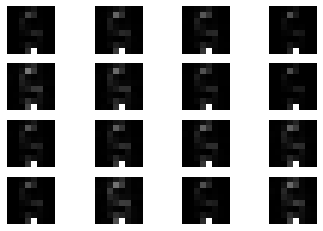

Epoch: 2, val nll=154.82387137276785
Epoch: 3, val nll=154.2244545200893
Epoch: 4, val nll=154.13005580357142
Epoch: 5, val nll=153.42605189732143
Saved!


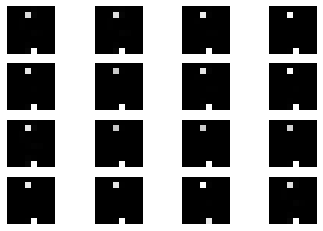

Epoch: 6, val nll=153.39111607142857
Saved!


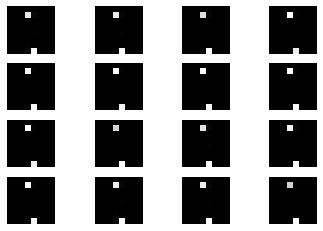

Epoch: 7, val nll=153.98531529017856
Epoch: 8, val nll=153.82185825892856
Epoch: 9, val nll=153.723046875
Epoch: 10, val nll=152.7603208705357
Saved!


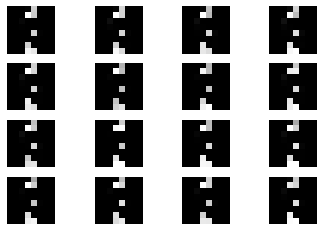

Epoch: 11, val nll=153.13586216517857
Epoch: 12, val nll=154.4045033482143
Epoch: 13, val nll=153.66334681919642
Epoch: 14, val nll=153.98888392857143
Epoch: 15, val nll=153.45564871651786
Epoch: 16, val nll=153.36079241071428
Epoch: 17, val nll=153.61396205357144
Epoch: 18, val nll=153.181396484375
Epoch: 19, val nll=152.99309430803572
Epoch: 20, val nll=152.43171177455358
Saved!


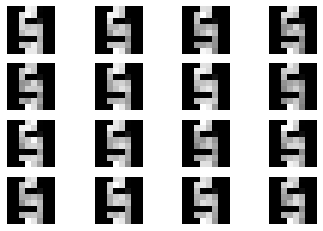

Epoch: 21, val nll=153.6659765625
Epoch: 22, val nll=152.67071149553573
Epoch: 23, val nll=153.5391796875
Epoch: 24, val nll=153.71445452008928
Epoch: 25, val nll=153.26369419642856
Epoch: 26, val nll=153.29292689732142
Epoch: 27, val nll=153.48716517857142
Epoch: 28, val nll=153.70462193080357
Epoch: 29, val nll=152.94479073660713
Epoch: 30, val nll=152.62651227678572
Epoch: 31, val nll=153.85201032366072
Epoch: 32, val nll=153.05695591517858
Epoch: 33, val nll=153.17784458705358
Epoch: 34, val nll=153.45566545758928
Epoch: 35, val nll=153.02557198660713
Epoch: 36, val nll=153.28645089285715
Epoch: 37, val nll=153.3937025669643
Epoch: 38, val nll=153.16205775669644
Epoch: 39, val nll=153.5332631138393
Epoch: 40, val nll=153.00181361607142
Epoch: 41, val nll=152.10534598214286
Saved!


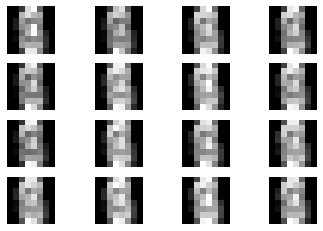

Epoch: 42, val nll=152.61385323660716
Epoch: 43, val nll=153.12018136160714
Epoch: 44, val nll=153.61923967633928
Epoch: 45, val nll=153.107724609375
Epoch: 46, val nll=152.93523018973215
Epoch: 47, val nll=153.59328962053573
Epoch: 48, val nll=153.26866629464286
Epoch: 49, val nll=153.00033482142857
Epoch: 50, val nll=153.64857979910715
Epoch: 51, val nll=153.51838309151785
Epoch: 52, val nll=153.5089536830357
Epoch: 53, val nll=153.37793247767857
Epoch: 54, val nll=153.46705775669642
Epoch: 55, val nll=153.22699776785714
Epoch: 56, val nll=153.39633510044644
Epoch: 57, val nll=153.54752650669644
Epoch: 58, val nll=153.42423828125
Epoch: 59, val nll=153.19231863839286
Epoch: 60, val nll=153.918388671875
Epoch: 61, val nll=153.16374720982142
Epoch: 62, val nll=152.80092354910715
Epoch: 63, val nll=153.12095284598215
Epoch: 64, val nll=153.348271484375
Epoch: 65, val nll=153.75513811383928
Epoch: 66, val nll=153.65839285714284
Epoch: 67, val nll=153.5249986049107
Epoch: 68, val nll=153.

In [91]:
# Training procedure
nll_val = training(name=str(RESULTS_DIR / model_name), 
                   max_patience=max_patience, 
                   num_epochs=num_epochs, 
                   model=model, 
                   optimizer=optimizer,
                   training_loader=training_loader, 
                   val_loader=val_loader)

## Evaluation

In [92]:
test_loss = evaluation(name=str(RESULTS_DIR / model_name), test_loader=test_loader)

FINAL LOSS: nll=153.0186289674217


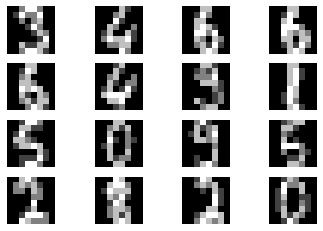

In [93]:
samples_real(str(RESULTS_DIR / model_name), test_loader)

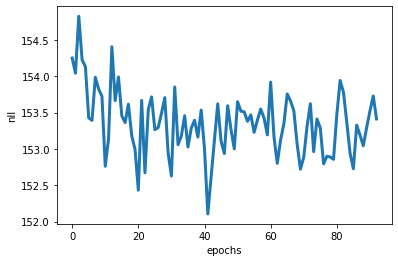

In [94]:
plot_curve(str(RESULTS_DIR / model_name), nll_val)

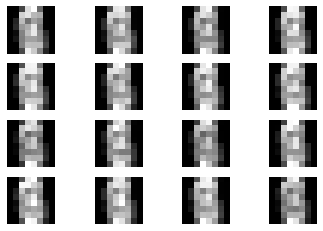

In [97]:
samples_generated(str(RESULTS_DIR / model_name), test_loader, extra_name="final")

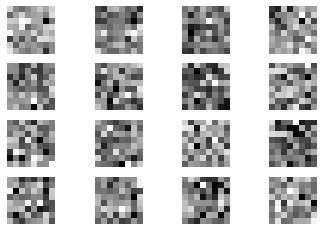

In [96]:
samples_diffusion(str(RESULTS_DIR / model_name), test_loader, extra_name="diffusion")